## Проект e-commerce

In [1]:
# импортирую необходимые библиотеки
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import datetime as dt
from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# выставляю настройки для отображения графиков
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize':(20,7)})

In [3]:
# считываю данные в три дата фрейма с помощью API
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'  
public_key_orders    = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_items     = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

final_url_customers = base_url + urlencode(dict(public_key=public_key_customers)) 
final_url_orders    = base_url + urlencode(dict(public_key=public_key_orders)) 
final_url_items     = base_url + urlencode(dict(public_key=public_key_items))

response_customers = requests.get(final_url_customers) 
response_orders    = requests.get(final_url_orders) 
response_items     = requests.get(final_url_items)

download_url_customers = response_customers.json()['href'] 
download_url_orders    = response_orders.json()['href'] 
download_url_items     = response_items.json()['href']

customers   = pd.read_csv(download_url_customers)
orders      = pd.read_csv(download_url_orders, parse_dates=['order_purchase_timestamp',
                                                                     'order_approved_at',
                                                                     'order_delivered_carrier_date',
                                                                     'order_delivered_customer_date',
                                                                     'order_estimated_delivery_date'])
order_items = pd.read_csv(download_url_items, parse_dates=['shipping_limit_date'])

#### 1. Определяю, что в данных можно считать заказом.
##### В данных есть заказы с подтверждённой оплатой, но в статусе «canceled». Поэтому в качестве покупок буду считать те заказы, по которым оплата была подтверждена и которые не были отменены.

In [4]:
orders.loc[orders.order_approved_at.notna()].order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'approved'], dtype=object)

In [5]:
purchases = orders.loc[(orders.order_approved_at.notna() & (orders.order_status != 'canceled'))]
purchases.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


#### 2. Определяю, сколько у нас пользователей, совершивших только одну покупку.

In [6]:
# оставляю только пользователей совершивших покупку
paying_users = customers.loc[customers.customer_id.isin(purchases.customer_id)]
# нахожу пользователей только с одной покупкой 
paying_users.groupby('customer_unique_id', as_index=False) \
            .agg({'customer_id' : 'count'}) \
            .rename(columns={'customer_id': 'num_purchases'}) \
            .query('num_purchases == 1')

,customer_unique_id,num_purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95538,fffcf5a5ff07b0908bd4e2dbc735a684,1
95539,fffea47cd6d3cc0a88bd621562a9d061,1
95540,ffff371b4d645b6ecea244b27531430a,1
95541,ffff5962728ec6157033ef9805bacc48,1


#### 3. Определяю, сколько заказов в месяц в среднем не доставляется по разным причинам
##### В данных есть заказы с непроставленной датой доставки, но в статусе «delivered». Поэтому за недоставленные заказы буду считать заказы, у которых не проставлено время доставки и заказ не находится в статусе «delivered»

In [7]:
orders.loc[orders.order_delivered_customer_date.isna()].order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

In [8]:
undelivered_orders = orders.loc[(orders.order_delivered_customer_date.isna()) & (orders.order_status != 'delivered')]                                                                                              
undelivered_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2957 entries, 6 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       2957 non-null   object        
 1   customer_id                    2957 non-null   object        
 2   order_status                   2957 non-null   object        
 3   order_purchase_timestamp       2957 non-null   datetime64[ns]
 4   order_approved_at              2811 non-null   datetime64[ns]
 5   order_delivered_carrier_date   1176 non-null   datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  2957 non-null   datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 207.9+ KB


##### Оставлю только заказы, по которым была подтверждена оплата, чтобы проанализировать причины, почему интернет-магазин теряет деньги из-за доставки

In [9]:
undelivered_orders = undelivered_orders.loc[undelivered_orders.order_approved_at.notna()]
undelivered_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2811 entries, 6 to 99415
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       2811 non-null   object        
 1   customer_id                    2811 non-null   object        
 2   order_status                   2811 non-null   object        
 3   order_purchase_timestamp       2811 non-null   datetime64[ns]
 4   order_approved_at              2811 non-null   datetime64[ns]
 5   order_delivered_carrier_date   1176 non-null   datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  2811 non-null   datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 197.6+ KB


In [10]:
# считаю количество месяцев в данных
num_months = orders.order_purchase_timestamp.dt.strftime('%Y-%m').nunique()

##### В среднем 24 заказа в месяц не доставляются из-за недоступности товара на складе

In [11]:
undelivered_orders.loc[undelivered_orders.order_status == 'unavailable'].shape[0] / num_months

24.36

##### И примерно 19 заказов в месяц не доставляются из-за отмены заказа на определённом этапе

In [12]:
undelivered_orders.loc[undelivered_orders.order_status == 'canceled'].shape[0] / num_months

19.12

##### Теперь проверю количество заказов, которые были отменены на этапе до передачи в логистическую службу и после  

In [13]:
canceled_orders = undelivered_orders.loc[undelivered_orders.order_status == 'canceled']
canceled_orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 478 entries, 397 to 99143
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       478 non-null    object        
 1   customer_id                    478 non-null    object        
 2   order_status                   478 non-null    object        
 3   order_purchase_timestamp       478 non-null    datetime64[ns]
 4   order_approved_at              478 non-null    datetime64[ns]
 5   order_delivered_carrier_date   69 non-null     datetime64[ns]
 6   order_delivered_customer_date  0 non-null      datetime64[ns]
 7   order_estimated_delivery_date  478 non-null    datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 33.6+ KB


In [14]:
# создаю дополнительную колонку с годом и месяцем заказа
canceled_orders['created_at'] = undelivered_orders.order_purchase_timestamp.dt.strftime('%Y-%m')
canceled_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,created_at
397,1b9ecfe83cdc259250e1a8aca174f0ad,6d6b50b66d79f80827b6d96751528d30,canceled,2018-08-04 14:29:27,2018-08-07 04:10:26,NaT,NaT,2018-08-14,2018-08
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaT,2018-02-22,2018-01
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaT,2018-02-23,2018-01
1811,0966b61e30c4a07edbd7523f59b3f3e4,2fcc597b8934d99715dbfff7909dd27f,canceled,2018-05-22 18:50:55,2018-05-22 19:17:15,NaT,NaT,2018-07-03,2018-05
1819,9021cf1919f615a121410790dcce848f,7acf55df0298e1d2c31200fb4f6fb93b,canceled,2018-07-04 16:05:56,2018-07-06 02:55:16,NaT,NaT,2018-08-22,2018-07


In [15]:
carrier = canceled_orders.groupby(['created_at', canceled_orders.order_delivered_carrier_date.isna()], as_index=False).size()
carrier.order_delivered_carrier_date.replace({True: 'before', False: 'after'}, inplace=True)
carrier.head()

,created_at,order_delivered_carrier_date,size
0,2016-09,before,2
1,2016-10,before,13
2,2017-01,before,2
3,2017-02,before,15
4,2017-03,before,31


##### В среднем в месяц 17 заказов до и 18 заказов после передачи в логистическую службу отменяются и не доставляются

In [16]:
carrier.groupby('order_delivered_carrier_date').agg({'size': 'mean'})

,size
order_delivered_carrier_date,
after,17.250000
before,18.590909


##### Осталось проверить в скольки случаях товар был поздно передан в логистическую службу

In [17]:
# дополняю дата-фрейм с отменёнными заказами колонкой shipping_limit_date
merged = canceled_orders.loc[canceled_orders.order_delivered_carrier_date.notna()] \
                        .merge(order_items, on='order_id') \
                        [['order_id', 'created_at', 'order_delivered_carrier_date', 'shipping_limit_date']]
merged.head()

,order_id,created_at,order_delivered_carrier_date,shipping_limit_date
0,714fb133a6730ab81fa1d3c1b2007291,2018-01,2018-01-29 22:33:25,2018-02-01 21:58:39
1,3a129877493c8189c59c60eb71d97c29,2018-01,2018-01-26 21:42:18,2018-01-31 13:50:20
2,8a9cce19aa49e055f2babb81d5a71c40,2018-02,2018-02-05 20:41:28,2018-02-08 02:52:42
3,c1049eef89915c6beb3604bf3d6588d7,2018-02,2018-02-09 22:13:01,2018-02-15 23:29:26
4,885935156ba43094f3ae95f3c14e0381,2018-02,2018-02-07 20:48:31,2018-02-20 02:55:37


##### В качестве критерия использую сравнение фактической даты передачи заказа в доставку и дедлайна для передачи. В итоге 8 заказов не были доставлены из-за того, что товар был поздно передан в логистическую компанию

In [18]:
merged.loc[merged.shipping_limit_date < merged.order_delivered_carrier_date]

,order_id,created_at,order_delivered_carrier_date,shipping_limit_date
9,5abf37ab57e23f69a9c8ab98c4800273,2018-01,2018-02-01 20:07:57,2018-02-01 00:36:35
32,2c0032906c603dcc21cd954828fa77d0,2018-02,2018-02-16 20:35:24,2018-02-12 15:55:40
36,854f8cb8dacdc3abc4cce7a7df6fcc1f,2018-02,2018-02-08 22:06:59,2018-02-08 09:15:27
37,fe9fae71b4fa7d05f1934adc54391f8d,2018-02,2018-02-21 19:59:14,2018-02-21 14:46:54
50,9ec3685b1f21c7dfff4f656392b186dd,2018-02,2018-02-27 16:17:59,2018-02-26 11:50:31
55,4472eca3b65b1dca5e0d59c0e4e0c6bc,2018-02,2018-02-15 22:22:46,2018-02-15 08:20:22
64,47e96b5cb6f0592d336b6bf8a817d1c3,2018-01,2018-02-01 00:08:56,2018-01-26 13:49:10
66,1def7af24cb7182497acfd953f6dd88b,2017-12,2018-01-30 19:28:55,2018-01-29 02:12:37


#### 4. По каждому товару определяю, в какой день недели товар чаще всего покупается
##### Соединяю таблицу с товарными позициями с таблицей с заказами, чтобы получить дату, которую потом преобразую в день недели

In [19]:
product_ids = order_items.merge(orders, on='order_id')[['order_id', 'product_id', 'order_purchase_timestamp']]
product_ids['weekday'] = product_ids.order_purchase_timestamp.dt.day_name()
product_ids.head()

,order_id,product_id,order_purchase_timestamp,weekday
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,2017-09-13 08:59:02,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,2017-04-26 10:53:06,Wednesday
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,2018-01-14 14:33:31,Sunday
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,2018-08-08 10:00:35,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,2017-02-04 13:57:51,Saturday


##### Фильтрую заказы по признаку «покупка», который определил в самом начале и считаю количество покупок каждого товара по дням недели

In [20]:
product_ids = product_ids[product_ids.order_id.isin(purchases.order_id)]

In [21]:
top_weekdays = product_ids.groupby(['product_id', 'weekday'], as_index=False) \
                          .agg({'order_id': 'count'}) \
                          .rename(columns={'order_id' : 'quantity'})
top_weekdays.head()

,product_id,weekday,quantity
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


In [22]:
top_weekdays['max_puchase_quantity'] = top_weekdays.groupby('product_id').quantity.transform('max')

In [23]:
top_weekdays.loc[top_weekdays.quantity == top_weekdays.max_puchase_quantity] \
            .sort_values('quantity', ascending=False)

,product_id,weekday,quantity,max_puchase_quantity
15814,422879e10f46682990de24d770e7f83d,Wednesday,93,93
36308,99a4788cb24856965c36a24e339b6058,Monday,92,92
40823,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89,89
20011,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76,76
13461,389d119b48cf3043d311335e499d9c6b,Thursday,67,67
...,...,...,...,...
23415,624763d3909ffa36098f91ce1e458ed4,Friday,1,1
23414,62410fbefbe7df2abf7e6b23e64255ee,Monday,1,1
23413,62410fbefbe7df2abf7e6b23e64255ee,Friday,1,1
23407,623eee74e76dce26984376983737af86,Thursday,1,1


#### 5. Считаю, сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)
##### Для этого для каждого пользователя считаю метрику PPW (purchases per week). В метрике учтено, что в месяце не всегда целое количество недель

In [24]:
# джойню таблицу с пользователями и таблицу с покупками
customer_orders = purchases.merge(customers, on='customer_id')[['order_id', 'customer_id', 'customer_unique_id', 'order_purchase_timestamp']]
# добавляю поля с месяцем и количеством недель в месяце, округлённое вниз до двух знаков
customer_orders['month'] = customer_orders.order_purchase_timestamp.dt.strftime('%Y-%m')
customer_orders['weeks_on_month'] = customer_orders.order_purchase_timestamp.dt.days_in_month / 7
customer_orders['weeks_on_month'] = customer_orders.weeks_on_month.apply(lambda x: np.floor(x * 100) / 100)
customer_orders.head()

,order_id,customer_id,customer_unique_id,order_purchase_timestamp,month,weeks_on_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10,4.42
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37,2018-07,4.42
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49,2018-08,4.42
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,7c142cf63193a1473d2e66489a9ae977,2017-11-18 19:28:06,2017-11,4.28
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13 21:18:39,2018-02,4.00


In [25]:
# считаю общее количество заказов пользователей по месяцам
customer_orders_per_month = customer_orders.groupby(['customer_unique_id', 'month', 'weeks_on_month'], as_index=False) \
                                 .agg({'order_id': 'count'}) \
                                 .rename(columns={'order_id': 'order_count'})
customer_orders_per_month.head()

,customer_unique_id,month,weeks_on_month,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.42,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.42,1
2,0000f46a3911fa3c0805444483337064,2017-03,4.42,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.42,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.28,1


In [26]:
# создаю поле с метрикой PPW — purchases per week
customer_orders_per_month['PPW'] = (customer_orders_per_month.order_count / customer_orders_per_month.weeks_on_month).round(3)
customer_orders_per_month.head()

,customer_unique_id,month,weeks_on_month,order_count,PPW
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,4.42,1,0.226
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,4.42,1,0.226
2,0000f46a3911fa3c0805444483337064,2017-03,4.42,1,0.226
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,4.42,1,0.226
4,0004aac84e0df4da2b147fca70cf8255,2017-11,4.28,1,0.234


In [27]:
# динамика по нашей метрике у самого частого пользователя
customer_orders_per_month.loc[customer_orders_per_month.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,month,weeks_on_month,order_count,PPW
53693,8d50f5eadf50201ccdcedfb9e2ac8455,2017-05,4.42,1,0.226
53694,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06,4.28,1,0.234
53695,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07,4.42,3,0.679
53696,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08,4.42,1,0.226
53697,8d50f5eadf50201ccdcedfb9e2ac8455,2017-09,4.28,1,0.234
53698,8d50f5eadf50201ccdcedfb9e2ac8455,2017-10,4.42,2,0.452
53699,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11,4.28,1,0.234
53700,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05,4.42,2,0.452
53701,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07,4.42,2,0.452
53702,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08,4.42,3,0.679


#### 6. Реализация когортного анализа пользователей

In [28]:
# получаю список с пользователями и временем совершения покупок 
user_purchases = customers.merge(purchases, on='customer_id')[['customer_unique_id', 'order_purchase_timestamp']]
user_purchases.head()

,customer_unique_id,order_purchase_timestamp
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30


In [29]:
# преобразую поле с timestamp в месяц покупки
def get_month(date):
    return dt.datetime(date.year, date.month, 1)

user_purchases['order_purchase_timestamp'] = user_purchases.order_purchase_timestamp.apply(get_month)
user_purchases.rename(columns={'order_purchase_timestamp': 'purchase_month'}, inplace=True)
user_purchases.head()

,customer_unique_id,purchase_month
0,861eff4711a542e4b93843c6dd7febb0,2017-05-01
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-01
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-01
3,259dac757896d24d7702b9acbbff3f3c,2018-03-01
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-01


In [30]:
# создаю колонку с первым месяцем активности пользователя (когортой)
user_purchases['cohort_month'] = user_purchases.groupby('customer_unique_id').purchase_month.transform('min')
user_purchases.loc[user_purchases.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,purchase_month,cohort_month
14102,8d50f5eadf50201ccdcedfb9e2ac8455,2017-11-01,2017-05-01
15231,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2017-05-01
16558,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,2017-05-01
35907,8d50f5eadf50201ccdcedfb9e2ac8455,2017-06-01,2017-05-01
37845,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2017-05-01
39902,8d50f5eadf50201ccdcedfb9e2ac8455,2017-07-01,2017-05-01
48315,8d50f5eadf50201ccdcedfb9e2ac8455,2018-07-01,2017-05-01
52247,8d50f5eadf50201ccdcedfb9e2ac8455,2017-08-01,2017-05-01
58326,8d50f5eadf50201ccdcedfb9e2ac8455,2018-08-01,2017-05-01
67545,8d50f5eadf50201ccdcedfb9e2ac8455,2018-05-01,2017-05-01


In [31]:
# считаю количество уникальных пользователей по дням активности внутри каждой когорты
cohorts = user_purchases.groupby(['cohort_month', 'purchase_month'], as_index=False) \
                        .agg({'customer_unique_id': pd.Series.nunique}) \
                        .sort_values(['cohort_month', 'purchase_month'])
cohorts.rename(columns={'customer_unique_id': 'total_users'}, inplace=True)
cohorts.head(20)

,cohort_month,purchase_month,total_users
0,2016-09-01,2016-09-01,2
1,2016-10-01,2016-10-01,297
2,2016-10-01,2017-04-01,1
3,2016-10-01,2017-07-01,1
4,2016-10-01,2017-09-01,1
5,2016-10-01,2017-11-01,1
6,2016-10-01,2018-01-01,1
7,2016-10-01,2018-03-01,1
8,2016-10-01,2018-05-01,2
9,2016-10-01,2018-06-01,2


In [32]:
# создаю поле cohort_index — порядковый номер активного месяца внутри когорты 
year_diff  = cohorts.purchase_month.dt.year - cohorts.cohort_month.dt.year
month_diff = cohorts.purchase_month.dt.month - cohorts.cohort_month.dt.month
cohorts['cohort_index'] = year_diff * 12 + month_diff
cohorts.head(20)

,cohort_month,purchase_month,total_users,cohort_index
0,2016-09-01,2016-09-01,2,0
1,2016-10-01,2016-10-01,297,0
2,2016-10-01,2017-04-01,1,6
3,2016-10-01,2017-07-01,1,9
4,2016-10-01,2017-09-01,1,11
5,2016-10-01,2017-11-01,1,13
6,2016-10-01,2018-01-01,1,15
7,2016-10-01,2018-03-01,1,17
8,2016-10-01,2018-05-01,2,19
9,2016-10-01,2018-06-01,2,20


In [33]:
# создаю поле с метрикой retention rate
first_date_users = cohorts.groupby('cohort_month').total_users.transform('max')
cohorts['retention_rate'] = cohorts.total_users / first_date_users
cohorts.head(20)

,cohort_month,purchase_month,total_users,cohort_index,retention_rate
0,2016-09-01,2016-09-01,2,0,1.000000
1,2016-10-01,2016-10-01,297,0,1.000000
2,2016-10-01,2017-04-01,1,6,0.003367
3,2016-10-01,2017-07-01,1,9,0.003367
4,2016-10-01,2017-09-01,1,11,0.003367
5,2016-10-01,2017-11-01,1,13,0.003367
6,2016-10-01,2018-01-01,1,15,0.003367
7,2016-10-01,2018-03-01,1,17,0.003367
8,2016-10-01,2018-05-01,2,19,0.006734
9,2016-10-01,2018-06-01,2,20,0.006734


In [34]:
# создаю сводную таблицу со значениями retention rate
cohorts['cohort_month'] = cohorts.cohort_month.dt.strftime('%Y-%m')
user_retention = cohorts.pivot(index='cohort_month', columns='cohort_index', values='retention_rate')
user_retention

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003367,NaN,NaN,0.003367,NaN,0.003367,NaN,0.003367,NaN,0.003367,NaN,0.003367,0.006734,0.006734
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.003947,0.002632,0.001316,0.003947,0.001316,0.005263,0.001316,0.001316,NaN,0.003947,0.001316,0.007895,0.003947,0.001316,0.001316,0.002632,0.003947,0.001316,NaN
2017-02,1.0,0.002322,0.002902,0.001161,0.004063,0.001161,0.002322,0.001741,0.001161,0.002322,0.001161,0.002902,0.001741,0.001741,0.001161,0.000580,0.000580,0.002322,NaN,NaN
2017-03,1.0,0.004994,0.003458,0.003842,0.003458,0.001537,0.001537,0.003073,0.003458,0.000768,0.003842,0.001537,0.002305,0.001153,0.001537,0.002305,0.000768,0.001537,NaN,NaN
2017-04,1.0,0.005998,0.002142,0.001714,0.002999,0.002571,0.003428,0.002999,0.002999,0.001714,0.002571,0.000857,0.000857,0.000428,0.000857,0.000857,0.001714,NaN,NaN,NaN
2017-05,1.0,0.004761,0.005041,0.003920,0.003080,0.003360,0.004201,0.001680,0.002520,0.002800,0.002520,0.003360,0.002520,0.000280,0.001960,0.002240,NaN,NaN,NaN,NaN
2017-06,1.0,0.004479,0.003519,0.004159,0.002559,0.003839,0.003519,0.002239,0.001280,0.002239,0.003199,0.003199,0.001599,0.001280,0.001919,NaN,NaN,NaN,NaN,NaN


##### Выявляю когорту с самым высоким retention на 3-й месяц в период с января по декабрь  

In [35]:
# делаю срез по нужному периоду и форматирую табличку для большей наглядности
retention_2017 = user_retention['2017-01':'2017-12']
r_style = (retention_2017
            .style
            .set_caption('User retention by cohort')  # добавляем подпись
            .background_gradient(cmap='BuGn')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
r_style

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
cohort_month,,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.39%,0.26%,0.13%,0.39%,0.13%,0.53%,0.13%,0.13%,,0.39%,0.13%,0.79%,0.39%,0.13%,0.13%,0.26%,0.39%,0.13%,
2017-02,100.00%,0.23%,0.29%,0.12%,0.41%,0.12%,0.23%,0.17%,0.12%,0.23%,0.12%,0.29%,0.17%,0.17%,0.12%,0.06%,0.06%,0.23%,,
2017-03,100.00%,0.50%,0.35%,0.38%,0.35%,0.15%,0.15%,0.31%,0.35%,0.08%,0.38%,0.15%,0.23%,0.12%,0.15%,0.23%,0.08%,0.15%,,
2017-04,100.00%,0.60%,0.21%,0.17%,0.30%,0.26%,0.34%,0.30%,0.30%,0.17%,0.26%,0.09%,0.09%,0.04%,0.09%,0.09%,0.17%,,,
2017-05,100.00%,0.48%,0.50%,0.39%,0.31%,0.34%,0.42%,0.17%,0.25%,0.28%,0.25%,0.34%,0.25%,0.03%,0.20%,0.22%,,,,
2017-06,100.00%,0.45%,0.35%,0.42%,0.26%,0.38%,0.35%,0.22%,0.13%,0.22%,0.32%,0.32%,0.16%,0.13%,0.19%,,,,,
2017-07,100.00%,0.52%,0.34%,0.26%,0.28%,0.21%,0.31%,0.10%,0.18%,0.26%,0.23%,0.31%,0.13%,0.26%,,,,,,
2017-08,100.00%,0.67%,0.34%,0.26%,0.36%,0.53%,0.29%,0.26%,0.14%,0.14%,0.24%,0.19%,0.12%,,,,,,,
2017-09,100.00%,0.68%,0.54%,0.29%,0.46%,0.22%,0.22%,0.24%,0.29%,0.17%,0.27%,0.07%,,,,,,,,


##### Из визуализации видно, что на 3-й месяц самый высокий retention у когорты 2017-06

#### 7. Реализация RFM-сегментации пользователей
- *R (recency) - время от последней покупки пользователя до текущей даты*
- *F (frequency) - суммарное количество покупок у пользователя за всё время*
- *M (monetary) - сумма покупок за всё время*

In [36]:
# получаю сумму по всем заказам
total_price = order_items.groupby('order_id', as_index=False).agg({'price': 'sum'})
total_price.head()

,order_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90


In [37]:
# подтягиваю уникальный идентификатор пользователя и время создания заказа
user_orders = purchases.merge(total_price, on='order_id') \
                       .merge(customers, on='customer_id') \
                       [['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price']]
user_orders.head()

,customer_unique_id,order_id,order_purchase_timestamp,price
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,45.00
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,19.90


In [38]:
# определяю текущую дату, как следующий день после последнего заказа в таблице
NOW = user_orders['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 09:06:57')

In [39]:
# вычисляю количество дней от каждой покупки до текущей даты 
user_orders['diff'] = user_orders.order_purchase_timestamp.apply(lambda x: (NOW - x).days)
user_orders.loc[user_orders.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,order_id,order_purchase_timestamp,price,diff
2317,8d50f5eadf50201ccdcedfb9e2ac8455,c2213109a2cc0e75d55585b7aaac6d97,2018-08-07 23:32:14,26.99,27
3625,8d50f5eadf50201ccdcedfb9e2ac8455,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21 22:44:31,45.99,105
5114,8d50f5eadf50201ccdcedfb9e2ac8455,e3071b7624445af6e4f3a1b23718667d,2017-09-05 22:14:52,39.90,363
11556,8d50f5eadf50201ccdcedfb9e2ac8455,d3582fd5ccccd9cb229a63dfb417c86f,2018-08-20 19:14:26,23.40,14
18890,8d50f5eadf50201ccdcedfb9e2ac8455,bf92c69b7cc70f7fc2c37de43e366173,2017-07-24 22:11:50,149.90,406
24563,8d50f5eadf50201ccdcedfb9e2ac8455,6bdf325f0966e3056651285c0aed5aad,2018-05-22 23:08:55,51.80,104
33288,8d50f5eadf50201ccdcedfb9e2ac8455,4f62d593acae92cea3c5662c76122478,2017-07-18 23:10:58,13.99,412
38965,8d50f5eadf50201ccdcedfb9e2ac8455,b850a16d8faf65a74c51287ef34379ce,2017-11-22 20:01:53,13.99,285
58074,8d50f5eadf50201ccdcedfb9e2ac8455,519203404f6116d406a970763ee75799,2017-08-05 08:59:43,69.90,395
65888,8d50f5eadf50201ccdcedfb9e2ac8455,a1a6eadae352582010f449d8527b55f3,2018-08-18 12:39:19,72.90,16


In [40]:
# агрегирую данные по каждому пользователю и получаю нужные показатели для сегментации
aggr = {'diff': 'min',
        'order_id': 'count',
        'price': 'sum'}

columns = {'diff': 'days_since_order',
           'order_id': 'order_count',
           'price': 'total_revenue'}

user_orders = user_orders.groupby('customer_unique_id', as_index=False) \
                         .agg(aggr) \
                         .rename(columns=columns)

user_orders.loc[user_orders.customer_unique_id == '8d50f5eadf50201ccdcedfb9e2ac8455']

,customer_unique_id,days_since_order,order_count,total_revenue
52349,8d50f5eadf50201ccdcedfb9e2ac8455,14,16,729.62


##### Теперь проверяю как распределены данные, чтобы определить границы для сегментации. 

<Axes: xlabel='days_since_order', ylabel='Count'>

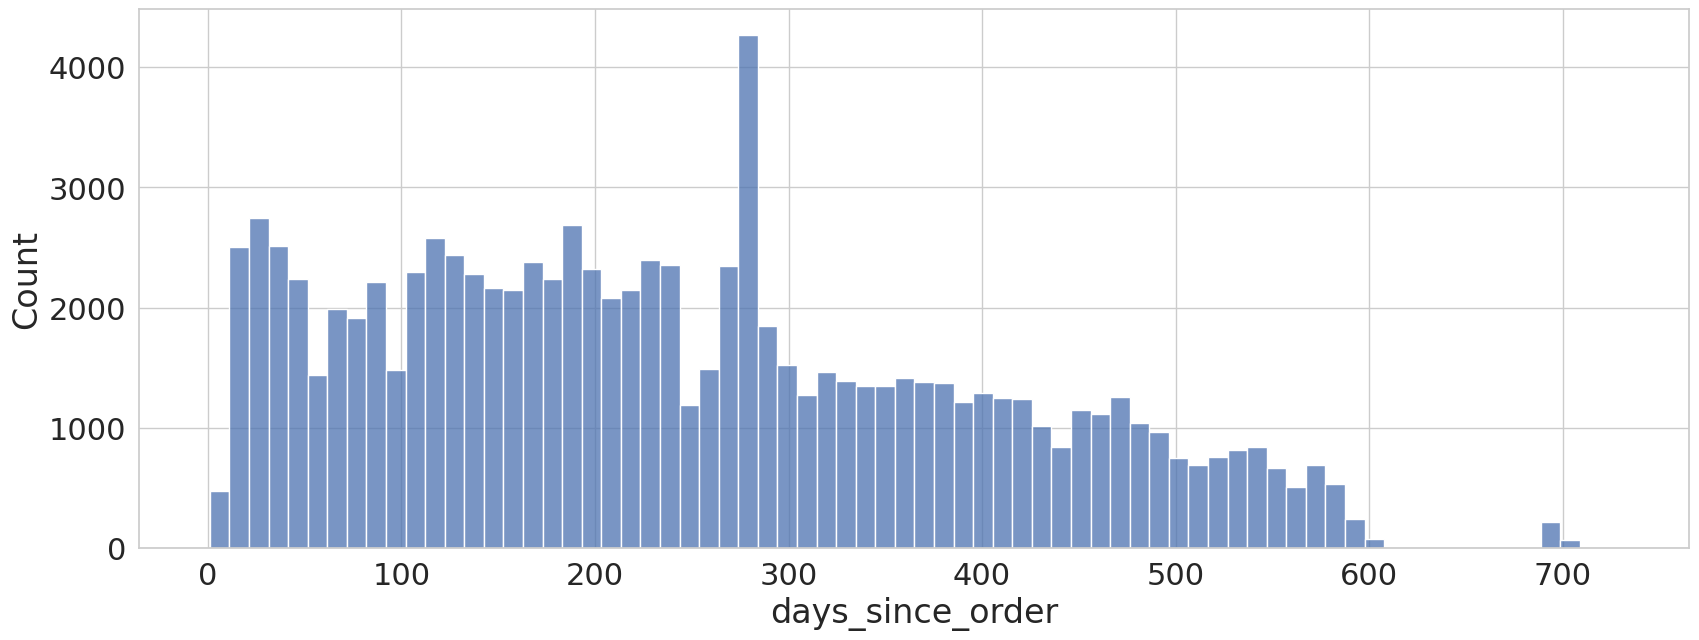

In [41]:
sns.histplot(user_orders.days_since_order)

##### «Количество дней с последнего заказа» распределены более-менее равномерно, поэтому эту колонку буду делить по квантилям

In [42]:
# выставляю параметры для нарезки на категории
quantiles = [0, 0.33, 0.66, 1]
bins = [user_orders.days_since_order.quantile(i) for i in quantiles]
labels = ['3', '2', '1']

# режу на категории
user_orders['recency'] = pd.cut(user_orders.days_since_order, bins=bins, labels=labels, include_lowest=True)
user_orders.head()

,customer_unique_id,days_since_order,order_count,total_revenue,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1


In [43]:
user_orders.order_count.value_counts()

order_count
1     92090
2      2650
3       188
4        29
5         9
6         5
7         3
9         1
16        1
Name: count, dtype: int64

##### «Общее количество заказов» имеет небольшой разброс значений, поэтому границы задаю вручную

In [44]:
bins = [1, 4, 7, 17]
labels = ['1', '2', '3']

user_orders['frequency'] = pd.cut(user_orders.order_count, bins=bins, labels=labels, right=False)
user_orders.head()

,customer_unique_id,days_since_order,order_count,total_revenue,recency,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1


<Axes: xlabel='total_revenue', ylabel='Count'>

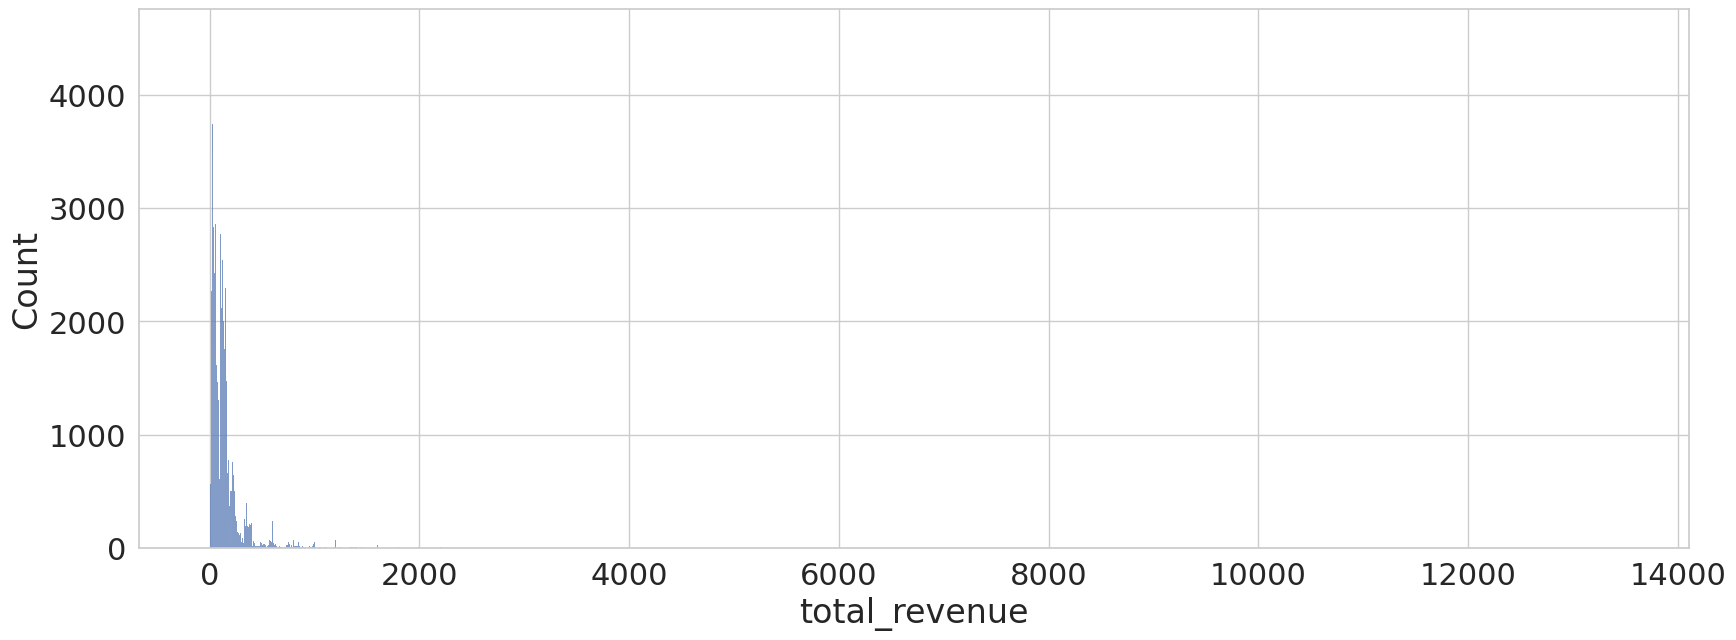

In [45]:
sns.histplot(user_orders.total_revenue)

##### В колонке с общей суммой покупок много значений с левой стороны распределения и есть часть экстремальных значений, поэтому границы задаю вручную

In [46]:
bins = [0, 1000 , 2000, 13441]
labels = ['1', '2', '3']

user_orders['monetary'] = pd.cut(user_orders.total_revenue, bins=bins, labels=labels, right=False)
user_orders.head()

,customer_unique_id,days_since_order,order_count,total_revenue,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,1


In [47]:
# cоединяю все показатели в метрику RFM_score
user_orders['RFM_score'] = user_orders.recency.astype(str) + user_orders.frequency.astype(str) + user_orders.monetary.astype(str)
user_orders.head()

,customer_unique_id,days_since_order,order_count,total_revenue,recency,frequency,monetary,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,1,311
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,1,111


In [48]:
user_orders.RFM_score.unique()

array(['311', '111', '211', '212', '113', '313', '312', '112', '321',
       '213', '121', '231', '221', '322', '232', '331', '323', '122'],
      dtype=object)

#### Теперь разбиваю всех пользователей на пять сегментов:
- потерянные клиенты - `lost_users`
- покупают немного, но постоянно - `loyal_users`
- покупают редко, но зато на большие суммы - `big_deal`
- новые клиенты - `new_users`
- остальные клиенты, требующие внимания - `need_attention`

In [49]:
segment_map = {
    r'11[1-2]': 'lost_users',
    r'[1-3]3[1-3]': 'loyal_users',
    r'[1-3]13': 'big_deal',
    r'3[1-3][1-3]': 'new_users',
    r'[1-2][1-2][1-2]': 'need_attention',
}

user_orders['segment'] = user_orders.RFM_score.replace(segment_map, regex=True)
user_orders.head()

,customer_unique_id,days_since_order,order_count,total_revenue,recency,frequency,monetary,RFM_score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,1,311,new_users
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,new_users
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1,111,lost_users
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,1,1,1,111,lost_users
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,1,1,1,111,lost_users


In [50]:
segment_counts = user_orders['segment'].value_counts()

<Axes: ylabel='segment'>

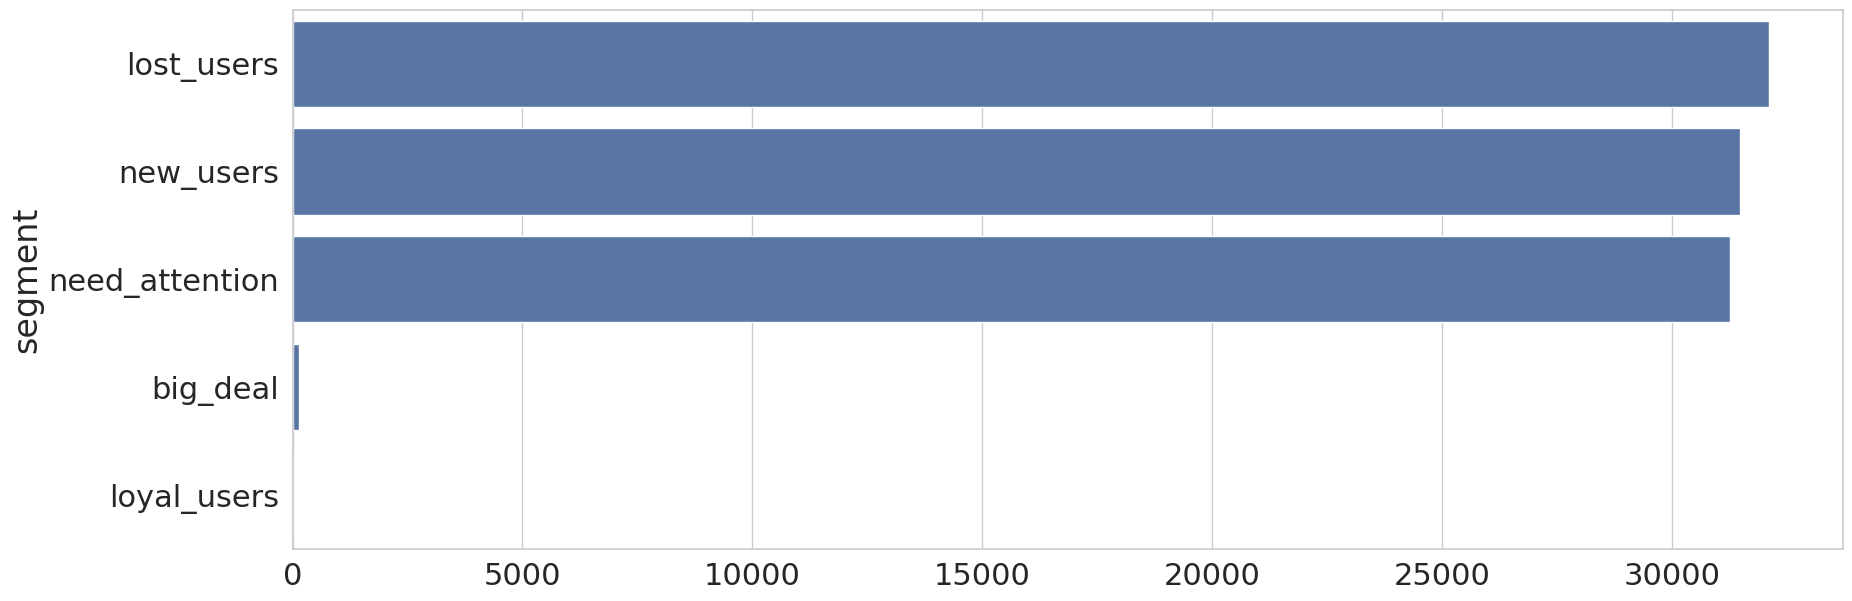

In [51]:
sns.barplot(x=segment_counts.values, y=segment_counts.index)

##### Из графика видно, что среди клиентов крайне мало лояльных пользователей и очень много потерянных. Несмотря на это, подавляющее большинство пользователей находятся в промежуточных сегментах (new_users и need_attention). Поэтому в продукте следует акцентировать внимание на повышении лояльности именно этих клиентов. 